In [140]:
#IMPORTS
import numpy as np
from numpy import exp
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import seaborn as sns
import statsmodels as s
from statsmodels import api as sm
from statsmodels.base.model import GenericLikelihoodModel
from statsmodels.api import Poisson  # WILL NOT NEED THIS OR SWITCH TO GAUSSIAN/NORMAL
from scipy import stats
from scipy.stats import norm
from scipy.special import factorial
from scipy.optimize import minimize
from statsmodels.iolib.summary2 import summary_col

In [141]:
#CLEAN DATA
#Read-in data
data = pd.read_csv('Health-Sciences-Data-File-New-(project).csv', usecols=list(range(0,35)))
#Clean column names
data.columns = data.columns.map(lambda x : x.replace("-", "_").replace(" ", "_"))
data.columns = data.columns.str.lower()
#Transform 'sex' values & data type
data.replace({'sex': 'M'}, {'sex': '0'}, regex=True, inplace=True)
data.replace({'sex': 'F'}, {'sex': '1'}, regex=True, inplace=True)
data = data.astype({"sex": np.int64})
#Drop identifier columns
data.drop(columns=['idnum', 'date'], inplace=True)
#Drop columns with NAs
#data.isna().sum()
data.drop(columns=['bia_percent_fat', 'sf_1', 'sf_2', 'sf_3', 'waist', 'pl_3', 'hr_3', 'rpe_3'], inplace=True)

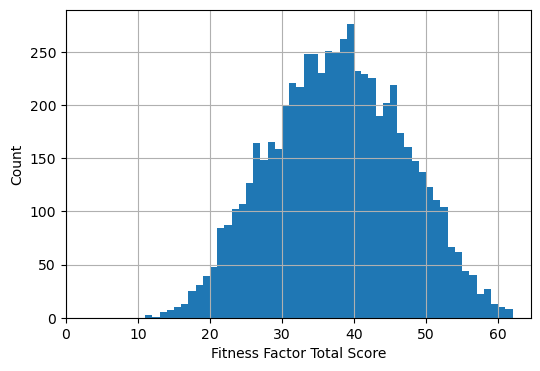

In [142]:
#CHECK REQUIREMENTS
#Check normality of FFTotal with histogram
plt.subplots(figsize=(6, 4))
plt.hist(data.loc[:, 'fftotal'], bins=range(min(data.loc[:, 'fftotal']), max(data.loc[:, 'fftotal']) + 1, 1))
plt.xlim(left=0)
plt.grid()
plt.xlabel('Fitness Factor Total Score')
plt.ylabel('Count')
plt.show()


In [143]:
#CREATE TRAINING DATASET
#add a constant
data['const'] = 1

#Create variable set order
reg1 = ['const', 'wt', 'ht', 'rgm', 'lgm', 'hr_2', 'hr_1', 'pl_2', 'pl_1', 'ff']
reg2 = ['const', "ff", "hr_2", "stages", "hr_1", "rgm", "lgm", "vc",
        "pl_2", "wt", "rpe_1", "pl_1", "rpe_2", "ht", "dbp", "hr_rest", "rf_2", 
        "sex", "sbp", "rf_3", "age", "rf_5", "pb", "ta", "rf_4"]
reg3 = ['const', "ff", "bmi", "hr_2", "stages", "hr_1", "rgm", "pl", "lgm", "vc",
        "pl_2", "wt", "rpe_1", "pl_1", "rpe_2", "ht", "dbp", "hr_rest", "rf_2", 
        "sex", "rpe", "hr", "sbp", "rf_3", "age", "rf_5", "pb", "ta", "rf_4"]

#Create training dataset
trainingindexes = pd.read_csv('trainingIndexes.csv')
trainingindexes = trainingindexes.astype({'indexes': np.int64})
trainingindexeslist = trainingindexes['indexes'].tolist()
trainingindexeslist = [x - 1 for x in trainingindexeslist]
trainingdata = data.iloc[trainingindexeslist,]

In [144]:
#TRAIN MLE MODEL

#Create Poisson model
#poisson_reg = sm.Poisson(trainingdata[['fftotal']], trainingdata[reg2]).fit(cov_type='HC0')
#print(poisson_reg.summary())

#Create Normal model
#Estimate initial parameters with OLS
model = sm.OLS(trainingdata[['fftotal']], trainingdata[reg2]).fit(cov_type='HC0')
initialParameters = model.params
initialParameters = initialParameters.to_numpy()
print(model.summary())

#Define Log-Likelihood Function
def _ll(y, X, betas, sigma):
    mu = X.dot(betas)
    return norm(mu,sigma).logpdf(y).sum()

#Define Maximum Likelihood Model Class
class MyMLE(GenericLikelihoodModel):
    def __init__(self, endog, exog, **kwds):
        super(MyMLE, self).__init__(endog, exog, **kwds)
    def nloglikeobs(self, params):
        sigma = params[-1]
        beta = params[:-1]
        ll = _ll(self.endog, self.exog, beta, sigma)
        return -ll
    def fit(self, start_params=None, maxiter=20000, maxfun=20000, **kwds):
        # we have one additional parameter and we need to add it for summary
        self.exog_names.append('sigma')
        if start_params == None:
            # Use initial parameter estimates and sigma
            start_params = np.append(initialParameters, .5)
        return super(MyMLE, self).fit(start_params=start_params,
                                     maxiter=maxiter, maxfun=maxfun,
                                     **kwds)

#Iteratively find optimal parameters
normal_mle_model = MyMLE(trainingdata[['fftotal']], trainingdata[reg2]).fit()
print(normal_mle_model.summary())

                            OLS Regression Results                            
Dep. Variable:                fftotal   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     1946.
Date:                Mon, 06 May 2024   Prob (F-statistic):               0.00
Time:                        01:03:09   Log-Likelihood:                -8962.8
No. Observations:                3138   AIC:                         1.798e+04
Df Residuals:                    3113   BIC:                         1.813e+04
Df Model:                          24                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.9661     12.930      2.163      0.0

c:\Users\4sreh\miniconda3\envs\fitnessprojenv\Lib\site-packages\statsmodels\base\model.py:2742: UserWarning: df_model + k_constant + k_extra differs from k_params
  warnings.warn("df_model + k_constant + k_extra "
c:\Users\4sreh\miniconda3\envs\fitnessprojenv\Lib\site-packages\statsmodels\base\model.py:2746: UserWarning: df_resid differs from nobs - k_params
  warnings.warn("df_resid differs from nobs - k_params")


In [145]:
#MODEL EVALUATION
#Get model coefficients
mle_model_betas = normal_mle_model.params
mle_model_betas = np.delete(mle_model_betas, 25)

#Calculate Model Predictions for Training Set
yhat = []
for index, row in trainingdata[reg2].iterrows():
    pred = row.dot(mle_model_betas)
    yhat = np.append(yhat, pred)

#Calulate R^2
ybar = trainingdata['fftotal'].sum()/len(trainingdata) # or sum(y)/len(y)
ssreg = np.sum((yhat-ybar)**2)                         # or sum([ (yihat - ybar)**2 for yihat in yhat])
sstot = np.sum((trainingdata['fftotal'] - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
RSq = ssreg / sstot
print(RSq)

#Create testing dataset
dataindexes = list(range(0, 6276))
testingindexesset = set(dataindexes) - set(trainingindexeslist)
testingindexeslist = list(testingindexesset)
testingdata = data.iloc[testingindexeslist,]

#Calculate Model Predictions for Testing Set
predictions = []
for index, row in testingdata[reg2].iterrows():
    pred = row.dot(mle_model_betas)
    predictions = np.append(predictions, pred)

#Append predictions to testing dataset
testingdata.loc[:, ['predictions']] = predictions

#Calculate RMSE
testingdata.loc[:, ['predictionError']] = testingdata['predictions'] - testingdata['fftotal']
testingdata.loc[:, ['predErrorSq']] = (testingdata['predictionError'])**2
errorSum = testingdata['predErrorSq'].sum()
lengthOfTestingData = len(testingdata)
RMSE =  (errorSum / lengthOfTestingData)**0.5
print(RMSE)

0.7976336532569985
4.146040711427465


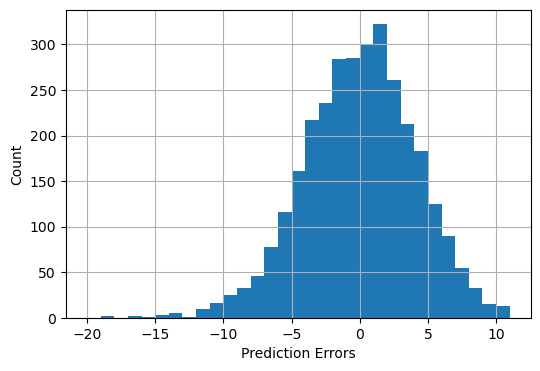

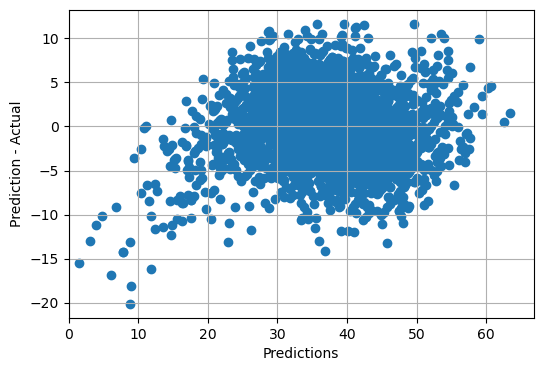

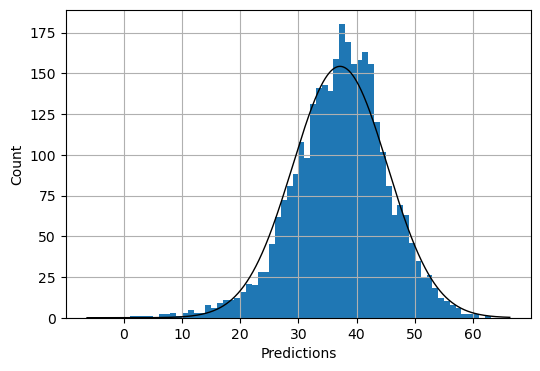

In [166]:
#PLOT THE ERRORS
plt.subplots(figsize=(6, 4))
plt.hist(testingdata.loc[:, 'predictionError'], bins=range(min(testingdata.loc[:, 'predictionError'].astype(int)), max(testingdata.loc[:, 'predictionError'].astype(int)) + 1, 1))
plt.grid()
plt.xlabel('Prediction Errors')
plt.ylabel('Count')
plt.show()
 
# plotting graph
# plt.plot(x, y)
plt.subplots(figsize=(6, 4))
plt.scatter(testingdata.loc[:, 'predictions'], testingdata.loc[:, 'predictionError'])
plt.xlim(left=0)
plt.grid()
plt.xlabel('Predictions')
plt.ylabel('Prediction - Actual')
plt.show()

plt.subplots(figsize=(6, 4))
plt.hist(testingdata.loc[:, 'predictions'], bins=range(min(testingdata.loc[:, 'predictions'].astype(int)), max(testingdata.loc[:, 'predictions'].astype(int)) + 1, 1))
plt.grid()
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
mu, std = norm.fit(testingdata['predictions'])
p = norm.pdf(x, mu, std)
plt.plot(x, p * 3138, 'k', linewidth=1)
plt.xlabel('Predictions')
plt.ylabel('Count')
plt.show()